# A Multi-Horizon Quantile Recurrent Forecaster

This is a prototype implementation of the *Multi-Horizon Quantile Recurrent Forecaster* with the following novelties:
- *quantile loss* vs *likelihood*
- *forking-* vs *cutting-sequences*
- *multi-horizon* vs *recursive*

---

## Coding

Imports:

In [1]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

---

### Model

##### Encoder:
* a standard LSTM.

##### Decoder:
* Global MLP: $ (c_{t+1},...,c_{t+K},c_a) = m_G(h_t,x_{t+1}^{(f)},...,x_{t+K}^{(f)}) $
* Local MLP: $ (\hat{y}_{t+1}^{q_1},...,\hat{y}_{t+1}^{q_Q};...;\hat{y}_{t+K}^{q_1},...,\hat{y}_{t+K}^{q_Q}) = m_L(c_{t+1},c_a,x_{t+1}^{(f)};...;c_{t+K},c_a,x_{t+K}^{(f)}) $

*K* is the forecast length.

In [2]:
class Encoder(pl.LightningModule):
    """Encoder network for MQ-RNN forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, input_size=4, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_units = hidden_units
    
        self.encoder = nn.LSTM(input_size=self.input_size + 1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)

    def forward(self, x, y):
        """
        Args:
        - x: (batch_size, hist_len, num_features)
        - y: (batch_size, hist_len)
        
        Returns:
        - hidden state: (batch_size, hidden_size)
        """
        y = y.unsqueeze(2)
        xy = torch.cat((x, y), dim=2)
        output, (henc, cenc) = self.encoder(xy)
        return henc[0]

In [3]:
class Decoder(pl.LightningModule):
    """Decoder network for MQ-RNN forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, input_size=4, hidden_units=8, num_quantiles=3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.num_quantiles = num_quantiles

        self.decoder_global = nn.Linear(in_features=(self.hidden_units + self.input_size) * self.fct_len,
                                        out_features=self.hidden_units * (self.fct_len + 1))
        self.decoder_local = nn.Linear(in_features=self.hidden_units * 2 + input_size,
                                       out_features=self.num_quantiles)

    def forward(self, h_t, x_f):
        """
        Args:
        - h_t: (batch_size, hidden_size, num_features)
        - x_f: (batch_size, fct_len, num_features)
        
        Returns:
        - predictions: (batch_size, fct_len, num_quantiles)
        """
        h_t = h_t.unsqueeze(1)
        h_t = h_t.expand(h_t.shape[0], self.fct_len, h_t.shape[2])
        hx = torch.cat((h_t, x_f), dim=2)
        hx = hx.view(x_f.shape[0], -1)

        c = self.decoder_global(hx)
        c = c.view(c.shape[0], self.fct_len + 1, -1)
        c_t = c[:,:-1]
        c_a = c[:, -1]
        
        preds = torch.zeros((h_t.shape[0], self.fct_len, self.num_quantiles), device=self.device)
        for k in range(self.fct_len):
            c_tk = c_t[:,k]
            x_fk = x_f[:,k]
            cx = torch.cat((c_tk, c_a, x_fk), dim=1)

            pred = self.decoder_local(cx)
            preds[:,k] = pred
        
        return preds

In [4]:
class MQRNN(pl.LightningModule):
    """MQ-RNN model"""
   
    def __init__(self, hist_len=168, fct_len=24, input_size=4, num_layers=1, hidden_units=8, quantiles=[0.1, 0.5, 0.9], lr=1e-3):
        super().__init__()

        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.quantiles = quantiles
        self.lr = lr

        self.encoder = Encoder(hist_len=self.hist_len,
                               fct_len=self.fct_len,
                               input_size=self.input_size,
                               num_layers=self.num_layers,
                               hidden_units=self.hidden_units)

        self.decoder = Decoder(hist_len=self.hist_len,
                               fct_len=self.fct_len,
                               input_size=self.input_size,
                               hidden_units=self.hidden_units,
                               num_quantiles=len(self.quantiles))

    def forward(self, x, y, x_f):
        ht = self.encoder(x, y)
        preds = self.decoder(ht, x_f)
        return preds

    def training_step(self, batch, batch_idx):
        x, y, x_f, y_f = batch
        preds = self(x, y, x_f)

        return self.loss(preds, y_f)

    def validation_step(self, batch, batch_idx):
        x, y, x_f, y_f = batch
        preds = self(x, y, x_f)

        loss = self.loss(preds, y_f)
        self.log('val_logprob', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def loss(self, preds, y):
        loss = 0
        z = torch.zeros_like(y)
        
        for i, q in enumerate(self.quantiles):
            pred = preds[:,:,i]
            dif = y - pred
            loss += q * torch.maximum(z, dif) + (1 - q) * torch.maximum(z, -dif)
        
        return loss.mean()

---

### Application

As depicted in the paper, we use the following datasets to experiment with the model:
- predict future demand of items sold on Amazon.com
- predict electricity price and load in a public probabilistic forecasting competition

In [5]:
import matplotlib.pyplot as plt

In [6]:
%pylab inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [7]:
import pathlib

In [8]:
import numpy as np
import pandas as pd

In [9]:
DATA_DIR = pathlib.Path('data')

---

### Amazon.com

Characteristics:
- weekly demand series of around 60K sampled products from different categories within the US marketplace gathered from 2012 to 2017.  
- data before 2016 is used to train the model, multi-horizon forecasts are created at each of the 52 weeks in 2016.
- forecats horizons range from 1 to 52 weeks

Covariates:
- past demand (history only)
- promotions (history and future)
- product catalog fields (static)

Training:
- quantiles are estimated for $ q \in \{0.1, 0.5, 0.9\} $ (P10, P50 and P90 forecasts)

##### Training

----

### GEFCom2014

2 problems were chosen: electricity load prediction and electricity price prediction.

Characteristics:
- the quantity to forecast is a single series of hour-grain price or load from several years

Covariates:
- there is no static series-related information

Training:
- there are 12 different forecast creation times (FCTs), for each one we use data prior the date for training, and then retrain from scratch for each subsequent forecast creation time
- quantiles are estimated for $ q \in \{0.01, 0.25, 0.5, 0.75, 0.99\} $, linear interpolation is used to produce the full set of 99 quantiles
- the competing metric for is a sum of quantile losses over 99 percentiles of the predicted distributions, and the average loss over the 12 forecast dates is the final evaluation criterion

##### Electricity Price

Problem:
- forecast hourly price distributions for a 24-hour horizon (24 × 99 quantile forecasts) of a particular zone

Covariates:
- past & future - zonal and total load forecasts for the horizon

Features:
- calendar-based features about the day of year and hour in a day, as well as weekday and US holiday indicators

Hyperparameters:
- history length - 168 hours (1 week)
- hidden unit size - 30

##### Training

##### Electricity Load

Problem:
- forecast hourly load distributions of a certain US utility for a month into the future (24 × 31 × 99 quantile forecasts)

Covariates:
- past - weather, temperature measurements of 25 weather stations

Features:
- calendar-based features

Hyperparameters:
- history length - 56 days (2 months)
- hidden unit size - 30

----

We'll start off with some EDA:

In [10]:
from datetime import datetime

In [11]:
date_parser = lambda date: datetime.strptime(date, '%m%d%Y %H:%M')

In [12]:
TASK = 1

In [13]:
path = DATA_DIR.joinpath(f'Load/Task {TASK}/L{TASK}-train.csv')
df = pd.read_csv(path, parse_dates=['TIMESTAMP'], index_col='TIMESTAMP', date_parser=date_parser)

In [14]:
df.shape

(85440, 27)

In [15]:
sum(df.isnull())

ZONEID        0
LOAD      35064
w1            0
w2            0
w3            0
w4            0
w5            0
w6            0
w7            0
w8            0
w9            0
w10           0
w11           0
w12           0
w13           0
w14           0
w15           0
w16           0
w17           0
w18           0
w19           0
w20           0
w21           0
w22           0
w23           0
w24           0
w25           0
dtype: int64

In [16]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [17]:
df = df.sort_index()
df.shape

(85440, 27)

In [18]:
df

,ZONEID,LOAD,w1,w2,w3,w4,w5,w6,w7,w8,...,w16,w17,w18,w19,w20,w21,w22,w23,w24,w25
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1,NaN,27,28,18,23,25,27,26,26,...,25,23,25,27,27,29,30,25,26,27
2001-01-01 02:00:00,1,NaN,25,28,18,23,24,24,26,24,...,25,23,25,27,23,28,30,24,22,27
2001-01-01 03:00:00,1,NaN,27,23,18,24,23,24,23,23,...,26,24,21,27,25,29,28,24,23,25
2001-01-01 04:00:00,1,NaN,25,21,19,24,23,24,22,23,...,25,24,21,27,23,27,28,23,26,25
2001-01-01 05:00:00,1,NaN,27,21,19,22,23,24,22,22,...,27,22,21,27,25,27,28,23,25,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-09 19:00:00,1,219.9,36,36,30,33,42,33,36,40,...,41,32,38,34,38,32,33,37,35,35
2010-12-09 20:00:00,1,222.3,35,36,28,32,41,32,36,39,...,40,31,37,30,38,31,32,37,29,34
2010-12-09 21:00:00,1,223.1,35,36,29,32,40,32,35,38,...,39,38,36,30,37,31,30,36,29,29


In [19]:
df[:35065]

,ZONEID,LOAD,w1,w2,w3,w4,w5,w6,w7,w8,...,w16,w17,w18,w19,w20,w21,w22,w23,w24,w25
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1,NaN,27,28,18,23,25,27,26,26,...,25,23,25,27,27,29,30,25,26,27
2001-01-01 02:00:00,1,NaN,25,28,18,23,24,24,26,24,...,25,23,25,27,23,28,30,24,22,27
2001-01-01 03:00:00,1,NaN,27,23,18,24,23,24,23,23,...,26,24,21,27,25,29,28,24,23,25
2001-01-01 04:00:00,1,NaN,25,21,19,24,23,24,22,23,...,25,24,21,27,23,27,28,23,26,25
2001-01-01 05:00:00,1,NaN,27,21,19,22,23,24,22,22,...,27,22,21,27,25,27,28,23,25,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-31 21:00:00,1,NaN,49,46,47,50,54,44,51,55,...,56,50,52,48,50,48,46,47,48,38
2004-12-31 22:00:00,1,NaN,47,46,43,50,54,47,49,54,...,54,46,52,46,48,48,46,48,48,40
2004-12-31 23:00:00,1,NaN,46,46,39,49,54,47,46,54,...,53,43,50,45,46,45,45,49,47,39


Start with the year 2005 (2001-2004 have `NaN` `LOAD` values):

In [20]:
new_idx = pd.date_range('2005-01-01 01:00:00', '2010-12-09 23:00:00', freq='1H')

In [21]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [22]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

In [23]:
dfi.shape

(52055, 27)

In [24]:
dfi.ZONEID.unique()

array([ 1., nan])

*ZONEID* is uninformative.

In [25]:
dfi = dfi[['LOAD'] + [f'w{i}' for i in range(1,26)]]

In [26]:
# for x in (dfi.index[i] for i in range(dfi.shape[0]) if dfi.iloc[i].isnull().LOAD):
#     print(x)

NaNs:
- Januarys of 2005-2010
- 2010 Oct, Nov

Overall available data:
* Feb-Dec of 2005-209
* Feb-Sep of 2010

In [27]:
dfs = [dfi.loc[f'{year}-2-1':f'{year}-12-31'] for year in ['2005', '2006', '2007', '2008', '2009']] + \
      [dfi.loc['2010-2-1':'2010-09-30']]

In [28]:
assert len(dfs) == 6

In [29]:
df05 = dfs[0]
df06 = dfs[1]
df07 = dfs[2]
df08 = dfs[3]
df09 = dfs[4]
df10 = dfs[5]

We'll use the features:
- hour-of-day
- day-of-week
- day-of-year
- temperatures *w1*-*w25*

----

### Data Module

In [30]:
class ElectricityLoadDataset(Dataset):
    """Sample data from electricity load dataset."""

    def __init__(self, df, samples, hist_len=168, fct_len=24):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)
        self.samples = samples

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df.copy()

        assert samples <= self.raw_data[:self.max_ts].shape[0]

        self.sample()

    def sample(self):
        """Sample individual series as needed."""

        nsamples = min(self.samples, self.raw_data.shape[0])
        self.samples = (self.raw_data
                        .loc[:self.max_ts]
                        .index
                        .to_series()
                        .sample(nsamples, replace=False)
                        .index
                        .sort_values()) # sort values to avoid predicting on already-trained data

        # Add calendar features
        self.raw_data['yearly_cycle'] = np.sin(2 * np.pi * self.raw_data.index.dayofyear / 366)
        self.raw_data['weekly_cycle'] = np.sin(2 * np.pi * self.raw_data.index.dayofweek / 7)
        self.raw_data['daily_cycle'] = np.sin(2 * np.pi * self.raw_data.index.hour / 24)
        self.calendar_features = ['yearly_cycle', 'weekly_cycle', 'daily_cycle']
        self.temperature_features = [f'w{i}' for i in range(1,26)]

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        start_ts = self.samples[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data_in = self.raw_data.loc[hs:, self.temperature_features + self.calendar_features].iloc[:self.hist_num]
        hist_data_out = self.raw_data.loc[hs:, ['LOAD']].iloc[:self.hist_num].LOAD
        fct_data_in = self.raw_data.loc[fs:, self.temperature_features + self.calendar_features].iloc[:self.fct_num]
        fct_data_out = self.raw_data.loc[fs:, ['LOAD']].iloc[:self.fct_num].LOAD

        return (torch.Tensor(hist_data_in.values),
                torch.Tensor(hist_data_out.values),
                torch.Tensor(fct_data_in.values),
                torch.Tensor(fct_data_out.values))

In [31]:
ds = ElectricityLoadDataset(df05, 100)

In [32]:
assert 100 == len(ds)

In [33]:
x, y, x_f, y_f = ds[4]

In [34]:
x.shape, y.shape

(torch.Size([168, 28]), torch.Size([168]))

In [35]:
x_f.shape, y_f.shape

(torch.Size([24, 28]), torch.Size([24]))

### Data Loader

In [36]:
import random

In [37]:
class ElectricityLoadDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self,
                 train_dfs,
                 val_df,
                 test_df,
                 train_samples=100,
                 val_samples=100,
                 test_samples=100,
                 batch_size=64,
                 workers=0):

        super().__init__()

        self.raw_trains = train_dfs
        self.raw_val = val_df
        self.raw_test = test_df
        
        self.train_samples = train_samples
        self.val_samples = val_samples
        self.test_samples = test_samples

        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_ds = [
                ElectricityLoadDataset(raw_train,
                                       samples=self.train_samples) for raw_train in self.raw_trains
            ]
            self.val_ds = ElectricityLoadDataset(self.raw_val,
                                                 samples=self.val_samples)

        if stage == 'test' or stage is None:
            self.test_ds = ElectricityLoadDataset(self.raw_test,
                                                  samples=self.test_samples)
    
    def train_dataloader(self):
#         current_loader = self.train_ds[self.current_epoch % len(self.train_ds)]
        current_loader = random.choice(self.train_ds)
        return DataLoader(current_loader, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [38]:
dm = ElectricityLoadDataModule([df05], df05, df05)
dm.setup()

In [39]:
x, y, x_f, y_f = next(iter(dm.train_dataloader()))

In [40]:
x.shape, y.shape

(torch.Size([64, 168, 28]), torch.Size([64, 168]))

In [41]:
x_f.shape, y_f.shape

(torch.Size([64, 24, 28]), torch.Size([64, 24]))

##### Training

In [42]:
mean05 = df05[df05!=0].mean()

In [43]:
scaled05 = df05 / mean05 - 1
scaled06 = df06 / mean05 - 1
scaled07 = df07 / mean05 - 1
scaled08 = df08 / mean05 - 1
scaled09 = df09 / mean05 - 1
scaled10 = df10 / mean05 - 1

In [44]:
train_dfs = [scaled05, scaled06, scaled07, scaled08]
dm = ElectricityLoadDataModule(train_dfs=train_dfs, val_df=scaled09, test_df=scaled10, train_samples=1000, batch_size=128)
model = MQRNN(hist_len=168, fct_len=24, input_size=28, num_layers=1, hidden_units=32, quantiles=[0.1, 0.5, 0.9], lr=1e-3)
trainer = pl.Trainer(max_epochs=30, progress_bar_refresh_rate=1, reload_dataloaders_every_epoch=True, gpus=1)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 8.1 K 
1 | decoder | Decoder | 1.2 M 
------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.645     Total estimated model params size (MB)


Epoch 0:  89%|▉| 8/9 [00:06<00:00,  1.28it/s, loss=0.499, v_num=29, val_logprob
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 9/9 [00:06<00:00,  1.30it/s, loss=0.499, v_num=29, val_logprob
Epoch 1:  89%|▉| 8/9 [00:05<00:00,  1.34it/s, loss=0.452, v_num=29, val_logprob
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 9/9 [00:06<00:00,  1.35it/s, loss=0.452, v_num=29, val_logprob
Epoch 2:  89%|▉| 8/9 [00:05<00:00,  1.34it/s, loss=0.383, v_num=29, val_logprob
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 9/9 [00:06<00:00,  1.35it/s, loss=0.383, v_num=29, val_logprob
Epoch 3:  89%|▉| 8/9 [00:05<00:00,  1.37it/s, loss=0.342, v_num=29, val_logprob
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/1 [00:00<?, ?it

Epoch 28: 100%|█| 9/9 [00:06<00:00,  1.35it/s, loss=0.13, v_num=29, val_logprob
Epoch 29:  89%|▉| 8/9 [00:05<00:00,  1.34it/s, loss=0.145, v_num=29, val_logpro
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/1 [00:00<?, ?it/s]
Epoch 29: 100%|█| 9/9 [00:06<00:00,  1.36it/s, loss=0.145, v_num=29, val_logpro
Epoch 29: 100%|█| 9/9 [00:06<00:00,  1.34it/s, loss=0.145, v_num=29, val_logpro


1

---

#### Example forecasts

Although the model must be trained in full longer and with larger number of layers, we still can capture the logistics of making the forecasts:

In [45]:
dm.setup(stage="test")

In [46]:
batch = next(iter(dm.test_dataloader()))

In [77]:
INDEX = 3

In [147]:
INDEX = 10

In [167]:
INDEX = 12

In [168]:
x, y, xf, yf = batch

In [169]:
x.shape, y.shape, xf.shape, yf.shape

(torch.Size([100, 168, 28]),
 torch.Size([100, 168]),
 torch.Size([100, 24, 28]),
 torch.Size([100, 24]))

In [170]:
x = x[INDEX].unsqueeze(0)
y = y[INDEX].unsqueeze(0)
xf = xf[INDEX].unsqueeze(0)
yf = yf[INDEX].unsqueeze(0)

In [171]:
x.shape, y.shape, xf.shape, yf.shape

(torch.Size([1, 168, 28]),
 torch.Size([1, 168]),
 torch.Size([1, 24, 28]),
 torch.Size([1, 24]))

In [172]:
preds = model(x, y, xf)

In [173]:
preds.shape

torch.Size([1, 24, 3])

In [174]:
preds[0].mean(dim=-1).shape

torch.Size([24])

In [175]:
yf[0].shape

torch.Size([24])

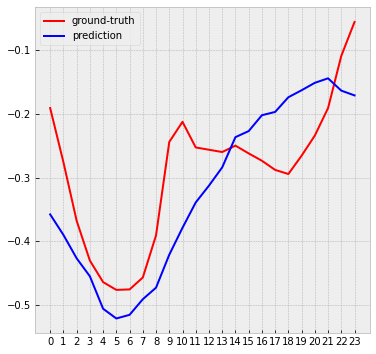

In [176]:
plt.plot(yf[0].numpy(), color='red', label='ground-truth')
plt.plot(preds[0].mean(dim=-1).detach().numpy(), color='blue', label='prediction')
plt.legend()
plt.xticks(np.arange(24))
plt.show()